# 问题哈密顿量
费米子表示的哈密顿量

In [4]:
import numpy as np
import scipy
from qiskit import QuantumCircuit, transpile
from qiskit.providers.aer import QasmSimulator
from qiskit.visualization import plot_histogram
from qiskit.quantum_info.operators import Operator, Pauli
import networkx as nx
from qiskit import Aer
import time
import warnings
warnings.filterwarnings("ignore")
import warnings
import optuna
import random as r
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')
optuna.logging.set_verbosity(optuna.logging.WARNING)
Z = Pauli('Z')
Z=Operator(Z)
I=Pauli('I')
I=Operator(I)
X = Pauli('X')
X=Operator(X)

In [5]:
H2_op=dict(
        [("II", -1.052373245772859),
        ("IZ", 0.39793742484318045),
        ("ZI", -0.39793742484318045),
        ("ZZ", -0.01128010425623538),
        ("XX", 0.18093119978423156),]
      )
matrix=np.kron(I,I)*(-1.052373245772859)+np.kron(I,Z)*(0.39793742484318045)+np.kron(Z,I)*(-0.39793742484318045)+np.kron(Z,Z)*(-0.01128010425623538)+np.kron(X,X)*(0.18093119978423156)
re,vec=np.linalg.eig(matrix)
print('真实值为：',min(re))


真实值为： (-1.8572750302023797+0j)


# 数值解

In [6]:
import numpy as np
from scipy.linalg import block_diag
from scipy.optimize import minimize

np.set_printoptions(precision=4,suppress=True)


# Pauli matrices
I  = np.array([[ 1, 0],
               [ 0, 1]])
Sx = np.array([[ 0, 1],
               [ 1, 0]])
Sy = np.array([[ 0,-1j],
               [1j, 0]])
Sz = np.array([[ 1, 0],
               [ 0,-1]])

# Hadamard matrix
H = (1/np.sqrt(2))*np.array([[ 1, 1],
                             [ 1,-1]])

# Phase matrix
S = np.array([[ 1, 0],
              [ 0,1j]])

# single qubit basis states |0> and |1>
q0 = np.array([[1],
               [0]])
q1 = np.array([[0],
               [1]])

# Projection matrices |0><0| and |1><1|
P0  = np.dot(q0,q0.conj().T)
P1  = np.dot(q1,q1.conj().T)


# Rotation matrices as a function of theta, e.g. Rx(theta), etc.
Rx = lambda theta : np.array([[    np.cos(theta/2),-1j*np.sin(theta/2)],
                              [-1j*np.sin(theta/2),    np.cos(theta/2)]])
Ry = lambda theta : np.array([[    np.cos(theta/2),   -np.sin(theta/2)],
                              [    np.sin(theta/2),    np.cos(theta/2)]])
Rz = lambda theta : np.array([[np.exp(-1j*theta/2),                0.0],
                              [                0.0, np.exp(1j*theta/2)]])

# CNOTij, where i is control qubit and j is target qubit
CNOT10 = np.kron(P0,I) + np.kron(P1,Sx) # control -> q1, target -> q0
CNOT01 = np.kron(I,P0) + np.kron(Sx,P1) # control -> q0, target -> q1

SWAP   = block_diag(1,Sx,1)

# See DOI: 10.1103/PhysRevX.6.031007
# Here, we use parameters given for H2 at R=0.75A
g0 = -1.052373245772859
g1 = 0.39793742484318045
g2 = -0.39793742484318045
g3 = -0.01128010425623538
g4 = 0.18093119978423156

#nuclear_repulsion = 0.7055696146
#哈密顿量在这里
Hmol = (g0 * np.kron( I, I) + # g0 * I
        g1 * np.kron( I,Sz) + # g1 * Z0
        g2 * np.kron(Sz, I) + # g2 * Z1
        g3 * np.kron(Sz,Sz) + # g3 * Z0Z1
        g4 * np.kron(Sx,Sx))  # g5 * X0X1

electronic_energy = np.linalg.eigvalsh(Hmol)[0] # take the lowest value
print("Classical diagonalization: {:+2.8} Eh".format(electronic_energy))
#print("Exact (from G16):          {:+2.8} Eh".format(-1.1457416808))

# initial basis, put in |01> state with Sx operator on q0
psi0 = np.zeros((4,1))
psi0[0] = 1
psi0 = np.dot(np.kron(I,Sx),psi0)
print(psi0)

# read right-to-left (bottom-to-top?)
ansatz = lambda theta: (np.dot(np.dot(np.kron(-Ry(np.pi/2),Rx(np.pi/2)),
                        np.dot(CNOT10, 
                        np.dot(np.kron(I,Rz(theta)),
                               CNOT10))),
                               np.kron(Ry(np.pi/2),-Rx(np.pi/2))))

def projective_expected(theta,ansatz,psi0):
    # this will depend on the hard-coded Hamiltonian + coefficients
    circuit = ansatz(theta[0])
    psi = np.dot(circuit,psi0)
    
    # for 2 qubits, assume we can only take Pauli Sz measurements (Sz \otimes I)
    # we just apply the right unitary for the desired Pauli measurement
    measureZ = lambda U: np.dot(np.conj(U).T,np.dot(np.kron(Sz,I),U))
    energy = 0.0
    
    # although the paper indexes the hamiltonian left-to-right (0-to-1) 
    # qubit-1 is always the top qubit for us, so the tensor pdt changes
    # e.g. compare with the "exact Hamiltonian" we explicitly diagonalized
    
    # <I1 I0> 
    energy += g0 # it is a constant
    a=energy
    #print(psi)
    # <I1 Sz0>
    U = SWAP
    energy += g1*np.dot(psi.conj().T,np.dot(measureZ(U),psi))
    #print(g1*np.dot(psi.conj().T,np.dot(measureZ(U),psi)),'energy2')
    b=g1*np.dot(psi.conj().T,np.dot(measureZ(U),psi))
    # <Sz1 I0>
    U = np.kron(I,I)
    energy += g2*np.dot(psi.conj().T,np.dot(measureZ(U),psi))
    #print(g2*np.dot(psi.conj().T,np.dot(measureZ(U),psi)),'enegy3')
    c=g2*np.dot(psi.conj().T,np.dot(measureZ(U),psi))
    # <Sz1 Sz0>
    U = CNOT01
    energy += g3*np.dot(psi.conj().T,np.dot(measureZ(U),psi))
    print(g3*np.dot(psi.conj().T,np.dot(measureZ(U),psi)),'energy4')
    d=g3*np.dot(psi.conj().T,np.dot(measureZ(U),psi))
   # print(measureZ(U))
    # <Sx1 Sx0>
    U = np.dot(CNOT01,np.kron(H,H))
    #U=np.kron(H,H)
    energy += g4*np.dot(psi.conj().T,np.dot(measureZ(U),psi))
    #print(g4*np.dot(psi.conj().T,np.dot(measureZ(U),psi)),'energy5')
    e=g4*np.dot(psi.conj().T,np.dot(measureZ(U),psi))
    #print(measureZ(U))
    #print((measureZ(U)))
    # <Sy1 Sy0>
    #U = np.dot(CNOT01,np.kron(np.dot(H,S.conj().T),np.dot(H,S.conj().T)))
    #energy += g5*np.dot(psi.conj().T,np.dot(measureZ(U),psi))
    print(a,b,c,d,e)
    return np.real(energy)[0,0]

theta  = [0.0]
result = minimize(projective_expected,theta,args=(ansatz,psi0))
theta  = result.x[0]
val    = result.fun

# check it works...
#assert np.allclose(val + nuclear_repulsion,-1.1456295)

print("VQE: ")
print("  [+] theta:  {:+2.8} deg".format(theta))
print("  [+] energy: {:+2.8} Eh".format(val))

Classical diagonalization: -1.857275 Eh
[[0.]
 [1.]
 [0.]
 [0.]]
[[0.0113-0.j]] energy4
-1.052373245772859 [[0.3979+0.j]] [[0.3979-0.j]] [[0.0113-0.j]] [[-0.+0.j]]
[[0.0113-0.j]] energy4
-1.052373245772859 [[0.3979+0.j]] [[0.3979-0.j]] [[0.0113-0.j]] [[-0.+0.j]]
[[0.0113-0.j]] energy4
-1.052373245772859 [[0.3914+0.j]] [[0.3914-0.j]] [[0.0113-0.j]] [[-0.0326+0.j]]
[[0.0113-0.j]] energy4
-1.052373245772859 [[0.3914+0.j]] [[0.3914-0.j]] [[0.0113-0.j]] [[-0.0326+0.j]]
[[0.0113-0.j]] energy4
-1.052373245772859 [[0.2459+0.j]] [[0.2459-0.j]] [[0.0113-0.j]] [[-0.1423+0.j]]
[[0.0113-0.j]] energy4
-1.052373245772859 [[0.2459+0.j]] [[0.2459-0.j]] [[0.0113-0.j]] [[-0.1423+0.j]]
[[0.0113-0.j]] energy4
-1.052373245772859 [[-0.3149+0.j]] [[-0.3149+0.j]] [[0.0113-0.j]] [[0.1106+0.j]]
[[0.0113-0.j]] energy4
-1.052373245772859 [[-0.3149+0.j]] [[-0.3149+0.j]] [[0.0113-0.j]] [[0.1106+0.j]]
[[0.0113-0.j]] energy4
-1.052373245772859 [[-0.3106+0.j]] [[-0.3106+0.j]] [[0.0113-0.j]] [[-0.1131+0.j]]
[[0.0113-0.j

# 自编VQE进行求解
使用正常方法与QAOA最概然期望法

In [7]:
import numpy as np
import scipy
from qiskit import QuantumCircuit, transpile
from qiskit.providers.aer import QasmSimulator
from qiskit.visualization import plot_histogram
from qiskit.quantum_info.operators import Operator, Pauli
import networkx as nx
from qiskit import Aer
import time
import warnings
warnings.filterwarnings("ignore")
import warnings
import optuna
import random as r
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')
optuna.logging.set_verbosity(optuna.logging.WARNING)
Z = Pauli('Z')
Z=Operator(Z)
I=Pauli('I')
I=Operator(I)
X = Pauli('X')
X=Operator(X)
def simi_result(circuit):#进行实验测量
    simulator = QasmSimulator()
    compiled_circuit = transpile(circuit, simulator)
    job = simulator.run(compiled_circuit, shots=1000)
    result = job.result()
    counts = result.get_counts(compiled_circuit)
    return counts


In [8]:
def circuit(the):
    cir = QuantumCircuit(2)
    cir.x(1)
    cir.ry(np.pi/2,0)
    cir.rx(-np.pi/2,1)
    cir.cx(0,1)
    cir.rz(the,1)
    cir.cx(0,1)
    cir.ry(-np.pi/2,0)
    cir.rx(np.pi/2,1)
    cir.barrier()
    return cir

In [9]:
def expctation2(the):
    Ham=0
    cir1=circuit(the)
    cir1.swap(0,1)
    cir1.measure_all()
    counts=simi_result(cir1)
    group=list(counts.keys())
    values=list(counts.values())
    temp_result1=0
    h1=0
    for i in range(0,len(group)):
        if group[i]=="00":
            temp_result1=1*0.39793742484318045*values[i]/1000
        elif group[i]=="01":
            temp_result1=-1*0.39793742484318045*values[i]/1000
        elif group[i]=="10":
            temp_result1=1*0.39793742484318045*values[i]/1000
        elif group[i]=="11":
            temp_result1=-1*0.39793742484318045*values[i]/1000
        else:
            print("err")
        h1=h1+temp_result1
        
    cir2=circuit(the)
    cir2.measure_all()
    counts2=simi_result(cir2)
    h2=0
    group=list(counts2.keys())
    values=list(counts2.values())
    temp_result2=0
    for i in range(0,len(group)):
        #print('group',group[i])
        if group[i]=="00":
            temp_result2=1*(-0.39793742484318045)*values[i]/1000
        elif group[i]=="01":
            temp_result2=-1*(-0.39793742484318045)*values[i]/1000
        elif group[i]=="10":
            temp_result2=1*(-0.39793742484318045)*values[i]/1000
        elif group[i]=="11":
            temp_result2=-1*(-0.39793742484318045)*values[i]/1000
        else:
            print("err")
        h2=h2+temp_result2
        
        
    cir3=circuit(the)
    cir3.measure_all()
    counts=simi_result(cir3)
    print(counts)
    group=list(counts.keys())
    values=list(counts.values())
    temp_result3=0
    h3=0
    for i in range(0,len(group)):
        if group[i]=="00":
            temp_result3=1*(-0.01128010425623538)*values[i]/1000
        elif group[i]=="01":
            temp_result3=-1*(-0.01128010425623538)*values[i]/1000
        elif group[i]=="10":
            temp_result3=-1*(-0.01128010425623538)*values[i]/1000
        elif group[i]=="11":
            temp_result3=1*(-0.01128010425623538)*values[i]/1000
        else:
            print("err")
        h3=h3+temp_result3
        
    cir4=circuit(the)
    cir4.h(0)
    cir4.h(1)
    cir4.measure_all()
    counts=simi_result(cir4)
    #print(counts)
    group=list(counts.keys())
    values=list(counts.values())
    temp_result4=0
    h4=0
    for i in range(0,len(group)):
        if group[i]=="00":
            temp_result4=1*0.18093119978423156*values[i]/1000
        elif group[i]=="01":
            temp_result4=-1*0.18093119978423156*values[i]/1000
        elif group[i]=="10":
            temp_result4=-1*0.18093119978423156*values[i]/1000
        elif group[i]=="11":
            temp_result4=1*0.18093119978423156*values[i]/1000
        else:
            print("err")
        h4=h4+temp_result4
        
    Ham=-1.052373245772859+h1+h2+h3+h4
    #print(Ham,'Ham')
    print(h1,h2,h3,h4)
    return Ham

In [10]:
def expctation(the):
    Ham=0
    cir1=circuit(the)
    cir1.swap(0,1)
    cir1.measure_all()
    counts=simi_result(cir1)
    #print(counts)
    group=list(counts.keys())
    values=list(counts.values())
    indexmax=values.index(max(values))
    maxnum=str(group[indexmax])
    temp_result1=0
    if maxnum=="00":
        temp_result1=1*0.39793742484318045
    elif maxnum=="01":
        temp_result1=-1*0.39793742484318045
    elif maxnum=="10":
        temp_result1=1*0.39793742484318045
    elif maxnum=="11":
        temp_result1=-1*0.39793742484318045
    else:
        print("err")
    
    cir2=circuit(the)
    cir2.measure_all()
    counts2=simi_result(cir2)
    group=list(counts2.keys())
    values=list(counts2.values())
    indexmax=values.index(max(values))
    maxnum=str(group[indexmax])
    temp_result2=0
    if maxnum=="00":
        temp_result2=1*(-0.39793742484318045)
    elif maxnum=="01":
        temp_result2=-1*(-0.39793742484318045)
    elif maxnum=="10":
        temp_result2=1*(-0.39793742484318045)
    elif maxnum=="11":
        temp_result2=-1*(-0.39793742484318045)
    else:
        print('err')
    #print('H2')
    
    cir3=circuit(the)
    cir3.measure_all()
    counts=simi_result(cir3)
    print(counts)
    group=list(counts.keys())
    values=list(counts.values())
    indexmax=values.index(max(values))
    maxnum=str(group[indexmax])
    temp_result3=0
    if maxnum=="00":
        temp_result3=1*(-0.01128010425623538)
    elif maxnum=="01":
        temp_result3=-1*(-0.01128010425623538)
    elif maxnum=="10":
        temp_result3=-1*(-0.01128010425623538)
    elif maxnum=="11":
        temp_result3=1*(-0.01128010425623538)
    else:
        print('err')
        
    cir4=circuit(the)
    cir4.h(0)
    cir4.h(1)
    cir4.measure_all()
    counts=simi_result(cir4)
    #print(counts)
    group=list(counts.keys())
    values=list(counts.values())
    indexmax=values.index(max(values))
    maxnum=str(group[indexmax])
    temp_result4=0
    if maxnum=="00":
        temp_result4=1*0.18093119978423156
    elif maxnum=="01":
        temp_result4=-1*0.18093119978423156
    elif maxnum=="10":
        temp_result4=-1*0.18093119978423156
    elif maxnum=="11":
        temp_result4=1*0.18093119978423156
    else:
        print('err')
        
    Ham=-1.052373245772859+temp_result1+temp_result2+temp_result3+temp_result4
    #print(Ham,'Ham')
    print(temp_result1,temp_result2,temp_result3,temp_result4)
    return Ham

In [12]:
def optifun1(x):
    x=list(x)
    the=x[0]
    exp=expctation(the)
    return exp
def cobyla1():
    x0=np.array(const_origin(1))
    bnd=bounds(1)
    result=scipy.optimize.minimize(optifun1,x0,method='COBYLA',bounds=bnd,options={'maxiter':100})
    pa=list(result.x)
    beta=[]
    gamma=[]
    return result

In [13]:
def optifun2(x):
    x=list(x)
    the=x[0]
    exp=expctation2(the)
    return exp
def bounds(p):
    a=(0,np.pi)
    b=(0,np.pi)
    bnd=[]
    for i in range(0,p):
        bnd.append(a)
    bnd=tuple(bnd)
    return bnd
def const_origin(p):
    origin=[]
    for i in range(0,p):
        origin.append(random())
    return origin
def random():
    weight=np.random.random()
    return weight
def cobyla2():
    x0=np.array(const_origin(1))
    bnd=bounds(1)
    result=scipy.optimize.minimize(optifun2,x0,method='COBYLA',bounds=bnd)
    pa=list(result.x)
    beta=[]
    gamma=[]
    return result

In [16]:
result2=cobyla2()
print("********")
result1=cobyla1()

{'10': 937, '01': 63}
-0.3509808087116852 -0.35655193265948965 0.011280104256235378 -0.08503766389858883
{'01': 461, '10': 539}
-0.04775249098118167 -0.04138549218369075 0.01128010425623538 -0.18093119978423156
{'10': 929, '01': 71}
-0.3358591865676443 -0.33108393746952614 0.01128010425623538 0.10059774708003275
{'10': 997, '01': 3}
-0.39793742484318045 -0.39793742484318045 0.011280104256235378 0.016283807980580843
{'10': 879, '01': 121}
-0.3048200674298762 -0.31118706622736714 0.01128010425623538 -0.1219476286545721
{'10': 976, '01': 24}
-0.37804055360102146 -0.374857054202276 0.01128010425623538 -0.05138446073872177
{'10': 989, '01': 11}
-0.385999302097885 -0.3915704260456896 0.011280104256235378 -0.04089045115123634
{'10': 999, '01': 1}
-0.3955498002941214 -0.39475392544443505 0.01128010425623538 -0.01230332158532775
{'10': 993, '01': 7}
-0.3931621757450623 -0.39236630089537594 0.011280104256235378 -0.025692230369360886
{'10': 977, '01': 23}
-0.3867951769475714 -0.3875910517972578 0

In [15]:
print(result2)
print(result1)

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -1.8533283978214
       x: [ 2.040e-01]
    nfev: 20
   maxcv: 0.0
 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -2.017899190987216
       x: [ 5.072e-01]
    nfev: 8
   maxcv: 0.0


# 小整理
通过对角化哈密顿量得到的能量值：-1.8572750302023797

数值法、正常方法、QAOA最概然期望方法得到各个子项的期望：

II:-1.052373245772859    -1.052373245772859      -1.052373245772859

IZ:-0.388            -0.38281580269913956    -0.39793742484318045 

ZI:-0.388            -0.38281580269913956    -0.39793742484318045

ZZ:0.0113            0.01128010425623538     0.01128010425623538

XX:-0.0401           -0.04704211194390021    -0.18093119978423156


说明最概然期望求法只适用于与经典问题对应的量子算法

对于量子化学使用不了

变分量子电路

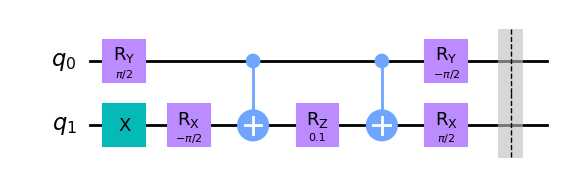

In [8]:
circuitshow=circuit(0.1)
circuitshow.draw('mpl')